# Task 0: Connect DuckDB with sakila database through the python API

In [1]:
import pandas as pd
import duckdb
from pathlib import Path

duckdb_path = "data/sakila.duckdb"
Path(duckdb_path).unlink(missing_ok=True)

with duckdb.connect(duckdb_path) as conn, open("sql/load_sakila.sql") as ingest_script:
    conn.sql(ingest_script.read())

    description = conn.sql("DESC;").df()
    films = conn.sql("FROM film;").df()

films.head(3)

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,<NA>,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2021-03-06 15:52:00
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,<NA>,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2021-03-06 15:52:00
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,<NA>,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2021-03-06 15:52:00


In [2]:

# look at the head() of the description dataframe
description.head()

,database,schema,name,column_names,column_types,temporary
0,sakila,main,actor,"[actor_id, first_name, last_name, last_update]","[DOUBLE, VARCHAR, VARCHAR, TIMESTAMP]",False
1,sakila,main,address,"[address_id, address, address2, district, city...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, VA...",False
2,sakila,main,category,"[category_id, name, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",False
3,sakila,main,city,"[city_id, city, country_id, last_update]","[BIGINT, VARCHAR, BIGINT, TIMESTAMP]",False
4,sakila,main,country,"[country_id, country, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",False


## Read everything from the description dataframe
**Code Reference from lecture notes**

In [3]:
# create a dictionary to keep all all dataframes
dfs = {}

with duckdb.connect(duckdb_path) as conn:
    for name in description["name"]:
        dfs[name] = conn.sql(f"FROM {name};").df()

In [4]:
# check the resulting dictionary
dfs.keys()

dict_keys(['actor', 'address', 'category', 'city', 'country', 'customer', 'customer_list', 'film', 'film_actor', 'film_category', 'film_list', 'film_text', 'inventory', 'language', 'payment', 'rental', 'sales_by_film_category', 'sales_by_store', 'staff', 'staff_list', 'store'])

## Register DataFrames to DuckDB
**Code Reference from lecture notes**

In [5]:
table_names = ['actor', 'address', 'category', 'city', 'country', 'customer', 'customer_list',
             'film', 'film_actor', 'film_category', 'film_list', 'film_text', 'inventory', 'language', 
             'payment', 'rental', 'sales_by_film_category', 'sales_by_store', 'staff', 'staff_list', 'store']

for table_name in table_names:
    duckdb.register(table_name, dfs[table_name])

In [6]:
# show the results of the registration
# Quick overview of all relations
duckdb.sql("DESC;").df()

,database,schema,name,column_names,column_types,temporary
0,temp,main,actor,"[actor_id, first_name, last_name, last_update]","[DOUBLE, VARCHAR, VARCHAR, TIMESTAMP]",True
1,temp,main,address,"[address_id, address, address2, district, city...","[BIGINT, VARCHAR, ""NULL"", VARCHAR, BIGINT, VAR...",True
2,temp,main,category,"[category_id, name, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",True
3,temp,main,city,"[city_id, city, country_id, last_update]","[BIGINT, VARCHAR, BIGINT, TIMESTAMP]",True
4,temp,main,country,"[country_id, country, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",True
5,temp,main,customer,"[customer_id, store_id, first_name, last_name,...","[BIGINT, BIGINT, VARCHAR, VARCHAR, VARCHAR, BI...",True
6,temp,main,customer_list,"[ID, name, address, zip_code, phone, city, cou...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, VARCHAR, V...",True
7,temp,main,film,"[film_id, title, description, release_year, la...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, BI...",True
8,temp,main,film_actor,"[actor_id, film_id, last_update]","[BIGINT, BIGINT, TIMESTAMP]",True
9,temp,main,film_category,"[film_id, category_id, last_update]","[BIGINT, BIGINT, TIMESTAMP]",True


In [7]:
# LLM here
out = []
for name in dfs.keys():
    df = duckdb.sql(f"DESCRIBE {name};").df()
    df["table_name"] = name
    out.append(df)
pd.concat(out, ignore_index= False)

,column_name,column_type,null,key,default,extra,table_name
0,actor_id,DOUBLE,YES,None,None,None,actor
1,first_name,VARCHAR,YES,None,None,None,actor
2,last_name,VARCHAR,YES,None,None,None,actor
3,last_update,TIMESTAMP,YES,None,None,None,actor
0,address_id,BIGINT,YES,None,None,None,address
...,...,...,...,...,...,...,...
7,SID,BIGINT,YES,None,None,None,staff_list
0,store_id,BIGINT,YES,None,None,None,store
1,manager_staff_id,BIGINT,YES,None,None,None,store
2,address_id,BIGINT,YES,None,None,None,store


----------------------------------------------------------------------------------------------------------------------------------------------

# Task 1: EDA with DuckDB and Pandas
### A) Which movies are longer than 3 hours (180 minutes), show the title and its length?

In [8]:
result_a = duckdb.sql("""--sql
SELECT 
    title,
    length
FROM
    film
WHERE
    length > 180
ORDER BY
    length DESC
                    """).df()

result_a

,title,length
0,WORST BANGER,185
1,CHICAGO NORTH,185
2,CONTROL ANTHEM,185
3,DARN FORRESTER,185
4,SWEET BROTHERHOOD,185
5,GANGS PRIDE,185
6,HOME PITY,185
7,SOLDIERS EVOLUTION,185
8,POND SEATTLE,185
9,MUSCLE BRIGHT,185


----------------------------------------------------------------------------------------------------------------------------------------------

### B) Which movies have the word "love" in its title? Show the following columns; title, rating, length, description

Use `ILIKE` instead of `LIKE` for case-insensitive search

In [9]:
result_b = duckdb.sql("""--sql
SELECT
    title,
    rating,
    length,
    description
FROM 
    film
WHERE
    title ILIKE 'love %'
    OR title ILIKE '% love'
""").df()

result_b

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
3,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
4,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


----------------------------------------------------------------------------------------------------------------------------------------------

### C) Calculate descriptive statistics on the length column, The Manager wants, shortest, average, median and longest movie length

In [40]:
# Check for missing values in length column

duckdb.sql("""--sql
SELECT 
    COUNT(*) AS missing_length
FROM film
WHERE length IS NULL;
""").df()


,missing_length
0,0


In [10]:
result_c = duckdb.sql("""--sql
SELECT
    MIN(length) AS shortest,
    AVG(length) AS average,
    MEDIAN(length) AS median,
    MAX(length) AS longest
FROM film;
""").df()

result_c

,shortest,average,median,longest
0,46,115.272,114.0,185


#### Extra EDA 1: Which runtime category monetizes best?
- Runtime bins (short / medium / long)
- Revenue aggregation per runtime bin
- Use **Common Table Expression (CTE)**
- A named, temporary result set created with `WITH`, which structures a logic step-by-step without nesting.

In [102]:
# Create bins (short / medium / long)
duckdb.sql("""--sql
SELECT film_id, title, length,
    CASE
        WHEN length < 90 THEN 'Short'
        WHEN length BETWEEN 90 AND 150 THEN 'Medium'
        ELSE 'Long'
    END AS length_band
FROM film
LIMIT 10;
""").df()

,film_id,title,length,length_band
0,1,ACADEMY DINOSAUR,86,Short
1,2,ACE GOLDFINGER,48,Short
2,3,ADAPTATION HOLES,50,Short
3,4,AFFAIR PREJUDICE,117,Medium
4,5,AFRICAN EGG,130,Medium
5,6,AGENT TRUMAN,169,Long
6,7,AIRPLANE SIERRA,62,Short
7,8,AIRPORT POLLOCK,54,Short
8,9,ALABAMA DEVIL,114,Medium
9,10,ALADDIN CALENDAR,63,Short


- Use `length_band` to segment films into **Short, Medium, and Long**
- Then quantify how many titles fall into each runtime category. 
- This highlights how the catalog is distributed across different film lengths.

In [103]:
duckdb.sql("""--sql
WITH film_band AS (
    SELECT film_id, title, length,
        CASE
            WHEN length < 90 THEN 'Short'
            WHEN length BETWEEN 90 AND 150 THEN 'Medium'
            ELSE 'Long'
        END AS length_band
    FROM film)

SELECT
    length_band, COUNT(*) AS film_count
FROM film_band
GROUP BY length_band
ORDER BY length_band DESC;
""").df()

,length_band,film_count
0,Short,320
1,Medium,438
2,Long,242


In [ ]:
# Final Query, added revenue, SELECT length_band, film_count, length_band_revenue into final result
duckdb.sql("""--sql
WITH film_band AS (
    SELECT f.film_id, f.title, f.length,
        CASE
            WHEN f.length < 90 THEN 'Short'
            WHEN f.length BETWEEN 90 AND 150 THEN 'Medium'
            ELSE 'Long'
        END AS length_band
    FROM film f),

revenue AS (
    SELECT
        fb.length_band,
        COUNT(DISTINCT fb.film_id) AS film_count,
        SUM(p.amount) AS length_band_revenue
    FROM film_band fb
    JOIN inventory i ON fb.film_id = i.film_id
    JOIN rental r    ON i.inventory_id = r.inventory_id
    JOIN payment p   ON r.rental_id = p.rental_id
    GROUP BY fb.length_band)

SELECT length_band, film_count, length_band_revenue
FROM revenue
ORDER BY length_band DESC;
""").df()

,length_band,film_count,length_band_revenue
0,Short,306,21392.59
1,Medium,419,30276.25
2,Long,233,15737.72


----------------------------------------------------------------------------------------------------------------------------------------------

### D) The rental rate is the cost to rent a movie and the rental duration is the number of days a customer can keep the movie.<br>
The Manager wants to know the **10 most expensive movies to rent per day.**<br>
<br>
Note: 
- The result flags a ranking ambiguity: many films share the same daily_price, so a strict “top 10” by descending value can produce more than 10 rows due to ties. 

- A better approach is to use `DENSE_RANK`, gives each film a rank based on the `daily_price`, even with ties.

- Another EDA I approached is to summarize the distribution. Show typical and high-end prices.

- Count how many films fall at each daily_price. This gives both a compact view of number of films per price levels<br>
<br>

**Key points to implement:**
| Step | Objective                                      | Method                                                                            |
|------|------------------------------------------------|-----------------------------------------------------------------------------------|
| 1    | Determine the daily rental cost for each film | Compute `daily_price    = rental_rate / rental_duration`                           |
| 2    | Prevent invalid calculations                  | Exclude records where `rental_duration`, etc equals 0                                  |
| 3    | Identify the highest-cost films               | Sort by `daily_price` in descending order and limit results to 10 rows            |
| 4   | Price distribution of film per daily_price    | Show summary stats (min, mean, median, max).                                     |
| 5    | Show number of films per daily_price band     | Group films into four simple bands: Low, Medium, High, Very High                 |


In [11]:
# 1 Quick check of the columns I need from film table
check_film = duckdb.sql("""--sql
SELECT
  film_id,
  rental_rate,
  rental_duration
FROM film
GROUP BY film_id, rental_rate, rental_duration
ORDER BY rental_rate DESC;
                        """).df()
check_film.head()

,film_id,rental_rate,rental_duration
0,845,4.99,7
1,179,4.99,4
2,8,4.99,6
3,798,4.99,4
4,47,4.99,5


In [46]:
# 2 Diagnose risk rows / bad inputs
duckdb.sql("""--sql
SELECT
    COUNT(*) AS total_rows,
    COUNT(*) FILTER (WHERE film_id IS NULL) AS film_id_missing,
    COUNT(*) FILTER (WHERE rental_rate IS NULL) AS rental_rate_missing,
    COUNT(*) FILTER (WHERE rental_duration IS NULL) AS rental_duration_missing
FROM film;
""").df()


,total_rows,film_id_missing,rental_rate_missing,rental_duration_missing
0,1000,0,0,0


In [13]:
# 3 Sorting WITHOUT DENSE RANK and OVER

task_d = duckdb.sql("""--sql
SELECT
    film_id,
    title,
    rental_rate,
    rental_duration,
    ROUND(rental_rate / rental_duration, 2) AS daily_price
FROM film
ORDER BY daily_price DESC
LIMIT 10;
              """).df()

# Make the index start at 1 instead of 0
task_d.index = range(1, len(task_d) + 1) 
task_d


,film_id,title,rental_rate,rental_duration,daily_price
1,21,AMERICAN CIRCUS,4.99,3,1.66
2,48,BACKLASH UNDEFEATED,4.99,3,1.66
3,71,BILKO ANONYMOUS,4.99,3,1.66
4,60,BEAST HUNCHBACK,4.99,3,1.66
5,120,CARIBBEAN LIBERTY,4.99,3,1.66
6,46,AUTUMN CROW,4.99,3,1.66
7,124,CASPER DRAGONFLY,4.99,3,1.66
8,2,ACE GOLDFINGER,4.99,3,1.66
9,65,BEHAVIOR RUNAWAY,4.99,3,1.66
10,126,CASUALTIES ENCINO,4.99,3,1.66


- **The problem with this result above is that the TOP 10 most expensive films to rent per day is not correct.**

- The query below fixes that using `WITH`, `DENSE_RANK`, `OVER` and the `WHERE` clause.

- `WITH`:<br> introduces a temporary, named subquery that exists only for the duration of the statement. This query inside the WITH is not wrong, the ranking is, so we can use it for the main query.

- `DENSE_RANK`:<br> Assigns rank numbers without gaps. When multiple films have the same daily_price, they all get the same rank (e.g., three films at the top price all get rank 1). The next distinct price gets rank 2, then 3, and so on.

- `OVER (ORDER BY daily_price DESC)`:<br> Tells SQL to look at all rows in their sorted order (highest daily_price first) and compute the rank for each row within that ordering, without collapsing rows like a `GROUP BY` would.

- Using `WHERE rnk <= 10`:<br> returns every film whose price falls within the first 10 ranks. This is “correct” when many films share the same top prices because it includes all tied entries instead of arbitrarily cutting them off at 10 rows.


In [ ]:
# help with LLM to formulate the 2nd and 3rd CTE 
# multiple ranks - aware 
duckdb.sql("""--sql
WITH x AS (
  SELECT
    f.film_id,
    f.title,
    f.rental_rate,
    f.rental_duration,
    ROUND(f.rental_rate / f.rental_duration, 2) AS daily_price
  FROM film f),
           
ranked AS (
  SELECT
    film_id, title, rental_rate, rental_duration, daily_price,
    DENSE_RANK() OVER (ORDER BY daily_price DESC) AS rank_num
  FROM x)
           
SELECT
  rank_num AS rank, title, daily_price, rental_rate, rental_duration
FROM ranked
WHERE rank_num <= 10
ORDER BY rank_num, title;
""").df()

,rank,title,daily_price,rental_rate,rental_duration
0,1,ACE GOLDFINGER,1.66,4.99,3
1,1,AMERICAN CIRCUS,1.66,4.99,3
2,1,AUTUMN CROW,1.66,4.99,3
3,1,BACKLASH UNDEFEATED,1.66,4.99,3
4,1,BEAST HUNCHBACK,1.66,4.99,3
...,...,...,...,...,...
732,10,VALLEY PACKER,0.33,0.99,3
733,10,WAIT CIDER,0.33,0.99,3
734,10,WEDDING APOLLO,0.33,0.99,3
735,10,WISDOM WORKER,0.33,0.99,3


#### EXTRA EDA 2: Analyze the price band distribution and aggregated film count per price band
Summarizes daily rental prices across all films.
Used Python and SQL for analysis.

- A: Show summary stats `(min, mean, median, max)`.
- B: Compute percentiles to show price distribution in bins (low, medium, high, very high) and show how many films per price band.

#### A: Show summary stats `(min, mean, median, max)`

In [16]:
# Compute daily_price distribution and percentiles with statistics
daily_stats = duckdb.sql("""--sql
SELECT
  COUNT(*)                               AS n,
  MIN(rental_rate / rental_duration)     AS min,
  AVG(rental_rate / rental_duration)     AS mean,
  MEDIAN(rental_rate / rental_duration)  AS median,
  MAX(rental_rate / rental_duration)     AS max
FROM film;
""").df()

daily_stats

,n,min,mean,median,max
0,1000,0.141429,0.649372,0.598,1.663333


#### B: Compute percentiles to show price distribution in bins (low, medium, high, very high)
**Help from LLM** <br>
Group films into four simple bands (Low, Medium, High, Very High)

Result:
| **Price Band**  | **Daily Price Range**     |
| --------------- | ------------------------- |
| Low price       | ≤ **0.598**               |
| Medium price    | > 0.598 and ≤ **0.9967**  |
| High price      | > 0.9967 and ≤ **1.2475** |
| Very High price | > **1.2475**              |


Code:
- Extracts the **“bin”** column from df which contains each film’s assigned price band.
- Counts how many films fall into each band using `value_counts()`
- Converts that result into a tidy table with `.reset_index()`, making it easier to read and use.

In [63]:
# THIS IS IN PYTHON FOR TESTING ACCURACY
# Counts per 4 simple price bands
# 1) Build a table of daily prices for all films
daily_price = duckdb.sql("""--sql
    SELECT 
        ROUND(rental_rate / rental_duration, 4) AS daily_price
    FROM film
""").df()

# 2) Using statistics, compute percentiles, HELP FROM LLM
low = float(daily_price['daily_price'].quantile(0.50))  # median
medium = float(daily_price['daily_price'].quantile(0.75))
high = float(daily_price['daily_price'].quantile(0.90))

# 3) Label each film into one of four bands
def bin_label(x):
    if x <= low:
        return "Low price"
    elif x <= medium:
        return "Medium price"
    elif x <= high:
        return "High price"
    else:
        return "Very High price"

daily_price['bin'] = daily_price['daily_price'].apply(bin_label) # LLM: Apply binning function

daily_price_counts = daily_price['bin'].value_counts().reset_index() # LLM: Count occurrences per bin
daily_price_counts.columns = ['Price Band', 'Count']   # LLM: Set column names
daily_price_counts

,Price Band,Count
0,Low price,540
1,Medium price,252
2,High price,146
3,Very High price,62


In [64]:
low, medium, high

(0.598, 0.9967, 1.2475)

In [ ]:
# Final Query in SQL all combined using CTE
duckdb.sql("""--sql
           
WITH daily_price AS (
    SELECT
        ROUND(rental_rate / rental_duration, 4) AS daily_price
    FROM film
),

thresholds AS (
    SELECT
        quantile_cont(daily_price, 0.50) AS low,
        quantile_cont(daily_price, 0.75) AS medium,
        quantile_cont(daily_price, 0.90) AS high
    FROM daily_price
),

banded AS (
    SELECT
        daily_price,
        CASE
            WHEN daily_price <= low THEN 'Low price'
            WHEN daily_price <= medium THEN 'Medium price'
            WHEN daily_price <= high THEN 'High price'
            ELSE 'Very High price'
        END AS price_band
    FROM daily_price, thresholds
)

SELECT
    price_band AS "Price Band",
    COUNT(*) AS "Number of Films"
FROM banded
GROUP BY price_band
ORDER BY COUNT(*) DESC;
""").df()

,Price Band,Number of Films
0,Low price,540
1,Medium price,252
2,High price,146
3,Very High price,62


Same results. Good.

----------------------------------------------------------------------------------------------------------------------------------------------

### E) Which actors have played in most movies?
Show the top 10 actors with the number of movies they have played in.
| Phase | Objective                               |
|-------|-------------------------------------------|
| 1     | Review tables and confirm structure       |
| 2     | Create  ranking of actors by film count |
| 3     | Handle the tiebrakers in the TOP 10 actors list |

In [18]:
# 1: scan of both actors and their film links.
# This validates structure of the tables

# Explore actor table and find the key column for joining
duckdb.sql("""--sql
SELECT
    actor_id,
    first_name,
    last_name
FROM actor
ORDER BY actor_id
LIMIT 10;
""").df()

,actor_id,first_name,last_name
0,1.0,PENELOPE,GUINESS
1,2.0,NICK,WAHLBERG
2,3.0,ED,CHASE
3,4.0,JENNIFER,DAVIS
4,5.0,JOHNNY,LOLLOBRIGIDA
5,6.0,BETTE,NICHOLSON
6,7.0,GRACE,MOSTEL
7,8.0,MATTHEW,JOHANSSON
8,9.0,JOE,SWANK
9,10.0,CHRISTIAN,GABLE


In [19]:
# 2: Extend the metric by inner joining the actor identity back into the counts.

actors_tiebraker_40 = duckdb.sql("""--sql
SELECT
  a.actor_id,
  a.first_name,
  a.last_name,
  COUNT(*) AS movie_count
FROM actor a
INNER JOIN film_actor fa ON a.actor_id = fa.actor_id
GROUP BY a.actor_id, a.first_name, a.last_name
ORDER BY movie_count DESC
LIMIT 40; 
""").df()

# Change index to start from 1
# Checked that from movie_count 42 - 32 has the actors with the most movies including all with tiebrakers
actors_tiebraker_40.index = range(1, len(actors_tiebraker_40) + 1)
actors_tiebraker_40

,actor_id,first_name,last_name,movie_count
1,107.0,GINA,DEGENERES,42
2,102.0,WALTER,TORN,41
3,198.0,MARY,KEITEL,40
4,181.0,MATTHEW,CARREY,39
5,23.0,SANDRA,KILMER,37
6,81.0,SCARLETT,DAMON,36
7,13.0,UMA,WOOD,35
8,144.0,ANGELA,WITHERSPOON,35
9,60.0,HENRY,BERRY,35
10,106.0,GROUCHO,DUNST,35


#### Tiebrakers in the actor's movie_count
- The result above shows that movie_count 42 - 32 has the actors with the most movies including all with tiebrakers.
- Therefore, need to group the ranking with actors sharing the same TOP 10 places.

#### Explain:
**Ranking the actors:**

- Rank actors by `movie_count` (ranked):
SELECT the same identity fields plus `movie_count` from `actor_counts`.

**Showing the TOP10:**
- `WITH`:<br> introduces a temporary, named subquery that exists only for the duration of the statement. This query inside the WITH is not wrong, the ranking is, so we can use it for the main query.

- `dense rank ()` gives a rank based on a sort order, and keeps ties together. If two actors have the same movie_count, they get the same rank.

- `OVER (...)` tells SQL to calculate a value across rows without collapsing them into one. It adds a “window” value per row.

- `OVER (ORDER BY movie_count DESC)` means: look at all actors, sort by movie_count from highest to lowest, and assign ranks in that sorted order.



In [101]:
# Tie-aware Top 10 actors by movie_count (include ties)
actors_ranked = duckdb.sql("""--sql
WITH actor_counts AS (
  SELECT a.actor_id, a.first_name, a.last_name, COUNT(*) AS movie_count
  FROM actor a
  INNER JOIN film_actor fa ON a.actor_id = fa.actor_id
  GROUP BY a.actor_id, a.first_name, a.last_name), 
                           
  ranked AS (   
  SELECT actor_id, first_name, last_name, movie_count,
    DENSE_RANK() OVER (ORDER BY movie_count DESC) AS rank
  FROM actor_counts)
                           
SELECT
  rank, first_name, last_name, movie_count
FROM ranked
WHERE rank <= 10
ORDER BY rank, last_name, first_name;
""").df()

# Change index to start from 1
actors_ranked.index = range(1, len(actors_ranked) + 1)
actors_ranked

,rank,first_name,last_name,movie_count
1,1,GINA,DEGENERES,42
2,2,WALTER,TORN,41
3,3,MARY,KEITEL,40
4,4,MATTHEW,CARREY,39
5,5,SANDRA,KILMER,37
6,6,SCARLETT,DAMON,36
7,7,VIVIEN,BASINGER,35
8,7,HENRY,BERRY,35
9,7,VAL,BOLGER,35
10,7,GROUCHO,DUNST,35


----------------------------------------------------------------------------------------------------------------------------------------------

## EXTRA EDA 3: Top 10 revenue-generating films and their genres
Identify star content to promote or license.
Tables conn: payment -> rental -> inventory -> film

- Join the tables step by step to confirm links
- Apply aggregation to calculate total revenue 
- Rank films to identify the top revenue drivers        
- Join the table to show each genres of the top 10 films

In [77]:
# Validating amount column
duckdb.sql("""--sql
SELECT 
    SUM(amount IS NULL) AS null_count
FROM payment;
""").df()

,null_count
0,0.0


In [73]:
# Top 10 revenue-generating films with genre
top_10_revenue_with_genre = duckdb.sql("""--sql
SELECT 
  f.film_id,
  f.title,
  c.name AS genre,
  ROUND(SUM(p.amount), 2) AS revenue
FROM payment p
JOIN rental r ON p.rental_id = r.rental_id
JOIN inventory i ON r.inventory_id = i.inventory_id
JOIN film f ON i.film_id = f.film_id
JOIN film_category fc ON fc.film_id = f.film_id
JOIN category c ON c.category_id = fc.category_id
GROUP BY f.film_id, f.title, c.name
ORDER BY revenue 
DESC, f.title ASC
LIMIT 10;
""").df()

top_10_revenue_with_genre.index = range(1, len(top_10_revenue_with_genre) + 1)
top_10_revenue_with_genre

,film_id,title,genre,revenue
1,879,TELEGRAPH VOYAGE,Music,231.73
2,973,WIFE TURN,Documentary,223.69
3,1000,ZORRO ARK,Comedy,214.69
4,369,GOODFELLAS SALUTE,Sci-Fi,209.69
5,764,SATURDAY LAMBS,Sports,204.72
6,893,TITANS JERK,Sci-Fi,201.71
7,897,TORQUE BOUND,Drama,198.72
8,403,HARRY IDAHO,Drama,195.70
9,460,INNOCENT USUAL,Foreign,191.74
10,444,HUSTLER PARTY,Comedy,190.78


----------------------------------------------------------------------------------------------------------------------------------------------

## EXTRA EDA 4: Top-earning ranking segments
- How many films exist in each rating category.
- How much revenue rating class generated.

In [66]:
ratings_analysis = duckdb.sql("""--sql
SELECT
    rating,
    COUNT(*) AS number_of_films
FROM film
GROUP BY rating
ORDER BY number_of_films DESC
""").df()

ratings_analysis

,rating,number_of_films
0,PG-13,223
1,NC-17,210
2,R,195
3,PG,194
4,G,178


In [70]:
ratings_revenue = duckdb.sql("""--sql
SELECT
    f.rating,
    SUM(p.amount) AS revenue_per_ratings
FROM film f
LEFT JOIN inventory i ON f.film_id = i.film_id
LEFT JOIN rental r ON i.inventory_id = r.inventory_id
LEFT JOIN payment p ON r.rental_id = p.rental_id
GROUP BY f.rating
ORDER BY revenue_per_ratings DESC;
""").df()

# Change index to start from 1
ratings_revenue.index = range(1, len(ratings_revenue) + 1)
ratings_revenue


,rating,revenue_per_ratings
1,PG-13,15259.16
2,NC-17,13875.07
3,PG,13337.91
4,R,13270.19
5,G,11664.23


----------------------------------------------------------------------------------------------------------------------------------------------

# Task 2: Graph Visualization

### A) Who are our top 5 customers by total spend? 

In [ ]:
top5_winners = duckdb.sql("""--sql
    SELECT
        c.customer_id,
        CONCAT(c.first_name, ' ', c.last_name) AS full_name,
        ROUND(SUM(p.amount), 2) AS total_spend
    FROM payment p
    JOIN customer c ON p.customer_id = c.customer_id
    GROUP BY c.customer_id, full_name
    ORDER BY total_spend DESC
    LIMIT 6;       
""").df()    

,customer_id,full_name,total_spend
0,526,KARL SEAL,221.55
1,148,ELEANOR HUNT,216.54
2,144,CLARA SHAW,195.58
3,137,RHONDA KENNEDY,194.61
4,178,MARION SNYDER,194.61
5,459,TOMMY COLLAZO,186.62


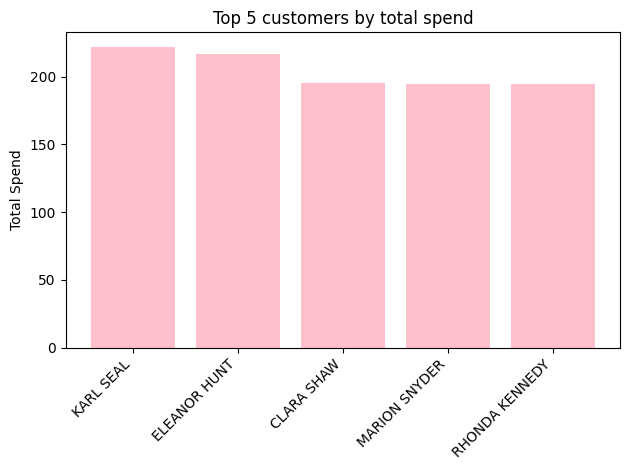

In [80]:
import matplotlib.pyplot as plt

df = top5_winners[['customer_name','total_spend']]
x = range(len(df))

plt.bar(x, df['total_spend'], color = 'pink')
plt.xticks(x, df['customer_name'], rotation = 45, ha = 'right', color = 'black')
plt.ylabel('Total Spend')
plt.title('Top 5 customers by total spend')
plt.tight_layout()
plt.show()

### B1) How much money does each film category bring in? 
This result will show which genres to increase to add more revenue

- Aggregate payments to films and then attribute each film’s revenue to its genre. 
- Join payment -> rental -> inventory -> film -> film_category -> category, 
- Sum the payment amounts per genre
- Sort the result by the revenue total in descending order.

----------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
top_genre_revenue = duckdb.sql("""--sql
SELECT
    c.name AS genre,
    ROUND(SUM(p.amount), 2) AS revenue
FROM payment p
JOIN rental r ON p.rental_id = r.rental_id
JOIN inventory i ON r.inventory_id = i.inventory_id
JOIN film f ON i.film_id = f.film_id
JOIN film_category fc ON fc.film_id = f.film_id
JOIN category c ON c.category_id = fc.category_id
GROUP BY c.name
ORDER BY revenue DESC;
""").df()

top_genre_revenue.index = range(1, len(top_genre_revenue) + 1)
top_genre_revenue

,genre,revenue
1,Sports,5314.21
2,Sci-Fi,4756.98
3,Animation,4656.30
4,Drama,4587.39
5,Comedy,4383.58
6,Action,4375.85
7,New,4351.62
8,Games,4281.33
9,Foreign,4270.67
10,Family,4226.07


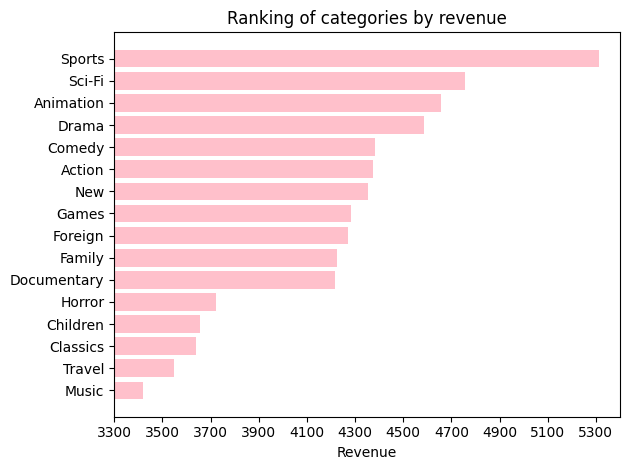

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# .copy() is used to avoid SettingWithCopyWarning
# .sort_values() to sort by revenue for better visualization
df = top_genre_revenue[['genre', 'revenue']].copy().sort_values('revenue')

# Create horizontal bar chart
fig, ax = plt.subplots()
ax.barh(df['genre'], df['revenue'], color='pink')
ax.set_xlabel('Revenue')
ax.set_title('Ranking of categories by revenue')

# Set x-axis limits and ticks
ax.set_xlim(3300, 5400)
ax.set_xticks(np.arange(3300, 5400, 200))

# Adjust layout and show plot
fig.tight_layout()
plt.show()

### B2) EXTRA EDA 5: Most number of films per genre
Tables/cols: film -> film_category -> category

In [30]:
# Final Query: Check how many films there are per genre
duckdb.sql("""--sql
SELECT
    fl.category,
    COUNT(*) AS film_count
FROM film_list AS fl
GROUP BY fl.category
ORDER BY film_count DESC, category;
""").df()

,category,film_count
0,Sports,441
1,Foreign,397
2,Documentary,385
3,Action,363
4,Animation,361
5,Drama,350
6,Family,347
7,Children,344
8,New,343
9,Sci-Fi,326


----------------------------------------------------------------------------------------------------------------------------------------------